# Online learning of AR(p) coefficients
$$p(\mathbf{x}_n\,|\,\mathbf{x}_{n-1},\mathbf{a},\gamma) = \mathcal{N}\left(\mathbf{x}_n \;\middle|\; \mathbf{A}\mathbf{x}_{n-1}, \mathbf{I}\gamma^{-1} \right)$$
where
\begin{align*}
    &\mathbf{x}_n = (x_n, x_{n-1}, \dots, x_{n-p+1})^\text{T} \quad \mathbf{x}_{n-1} = (x_{n-1}, x_{n-2}, \dots, x_{n-p})^\text{T} 
    \\ \\
    &\mathbf{A} = 
    \begin{bmatrix}
        a_1 & a_2 & a_3 & \dots & a_p \\
        1 & 0 & 0 & \dots & 0 \\ 
        0 & 1 & 0 & \dots & 0 \\   
        \vdots & \vdots & \vdots & \ddots & \vdots \\
        0 & 0 & 0 & \dots & 0
    \end{bmatrix}
    =
    \begin{bmatrix}
         \mathbf{a}^\text{T} \\
         \mathbf{I}_{p-1} \quad \mathbf{0}
    \end{bmatrix}
    \\ \\
    &\mathbf{I} = \mathbf{I}_p = 
    \begin{bmatrix}
        1 & 0 & 0 & \dots & 0 \\ 
        0 & 1 & 0 & \dots & 0 \\   
        \vdots & \vdots & \vdots & \ddots & \vdots \\
        0 & 0 & 0 & \dots & 1
    \end{bmatrix}
\end{align*}

┌ Info: Precompiling Images [916415d5-f1e6-5110-898d-aaa5f9f070e0]
└ @ Base loading.jl:1186
┌ Info: Precompiling QuartzImageIO [dca85d43-d64c-5e67-8c65-017450d5d020]
└ @ Base loading.jl:1186


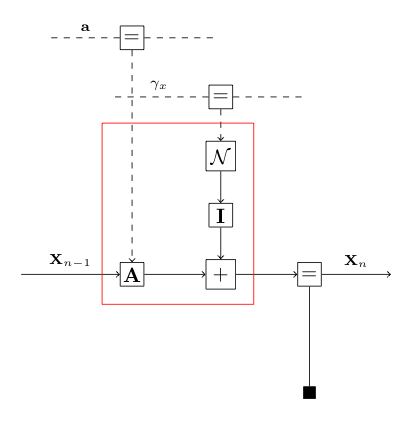

In [1]:
using Images
img = load("../ffgs/AR-online.png")

We are interested in a joint estimation of the AR coefficients $\mathbf{a}$, the precision  of the driving noise $\gamma$

In [16]:
using ProgressMeter
using Revise
using ForneyLab
include("../AR-node/autoregression.jl")
include("../AR-node/rules_prototypes.jl")
include("../AR-node/vmp_rules.jl")
# helpers for evaluation of the model
include("../helpers.jl")
# module to generate data for AR
include("../data/ARdata.jl")
import Main.ARdata: use_data, generate_data
import LinearAlgebra.I, LinearAlgebra.Symmetric
import ForneyLab: unsafeCov, unsafeMean, unsafePrecision

In [24]:
ARorder = 10 # order of AR model
diagAR(dim) = Matrix{Float64}(I, dim, dim)
x = []
# Coefs and Observations
coefs, x = generate_data(10000, ARorder, 1, noise_variance=0.1)

([-0.221843, 0.0960999, -0.0162155, 0.019213, -0.419278, -0.23612, -0.116385, -0.0959833, -0.357645, 0.00349174], Array{Float64,1}[[-0.43931, -0.391835, -0.278556, 0.369086, 1.11299, 0.450886, 0.316231, -0.0839523, -0.0210019, 0.000188716], [-0.485192, -0.43931, -0.391835, -0.278556, 0.369086, 1.11299, 0.450886, 0.316231, -0.0839523, -0.0210019], [-0.484767, -0.485192, -0.43931, -0.391835, -0.278556, 0.369086, 1.11299, 0.450886, 0.316231, -0.0839523], [-0.093834, -0.484767, -0.485192, -0.43931, -0.391835, -0.278556, 0.369086, 1.11299, 0.450886, 0.316231], [-0.301524, -0.093834, -0.484767, -0.485192, -0.43931, -0.391835, -0.278556, 0.369086, 1.11299, 0.450886], [0.236654, -0.301524, -0.093834, -0.484767, -0.485192, -0.43931, -0.391835, -0.278556, 0.369086, 1.11299], [0.658737, 0.236654, -0.301524, -0.093834, -0.484767, -0.485192, -0.43931, -0.391835, -0.278556, 0.369086], [0.449244, 0.658737, 0.236654, -0.301524, -0.093834, -0.484767, -0.485192, -0.43931, -0.391835, -0.278556], [0.56122

In [25]:
g = FactorGraph()

# declare priors as random variables
@RV m_x_t_prev
@RV w_x_t_prev
@RV m_x_t
@RV w_x_t
@RV a_w_t
@RV b_w_t
@RV m_a_t
@RV w_a_t

@RV a ~ GaussianMeanPrecision(m_a_t, w_a_t)
@RV x_t_prev ~ GaussianMeanPrecision(m_x_t_prev, w_x_t_prev)
@RV x_t ~ GaussianMeanPrecision(m_x_t, w_x_t)
@RV w ~ Gamma(a_w_t, b_w_t)
Autoregression(x_t, x_t_prev, a, w)

# Placeholders for prior
placeholder(a_w_t, :a_w_t)
placeholder(b_w_t, :b_w_t)
placeholder(m_a_t, :m_a_t, dims=(ARorder,))
placeholder(w_a_t, :w_a_t, dims=(ARorder, ARorder))

# Placeholder for data
placeholder(m_x_t_prev, :m_x_t_prev, dims=(ARorder,))
placeholder(w_x_t_prev, :w_x_t_prev, dims=(ARorder, ARorder))
placeholder(m_x_t, :m_x_t, dims=(ARorder,))
placeholder(w_x_t, :w_x_t, dims=(ARorder, ARorder))

ForneyLab.draw(g)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 5631559122040787030 -->
 
 5631559122040787030 
 
 placeholder_a_w_t 
 
<!-- 6053369646629523709 -->
 
 6053369646629523709 
 
 Gam 
 gamma_1 
 
<!-- 5631559122040787030--6053369646629523709 -->
 
 5631559122040787030--6053369646629523709 
 
 a_w_t 
 2 a 
 1 out 
 
<!-- 12509871783932880352 -->
 
 12509871783932880352 
 
 𝒩 
 gaussianmeanprecision_3 
 
<!-- 17014891355036284457 -->
 
 17014891355036284457 
 
 placeholder_b_w_t 
 
<!-- 17014891355036284457--6053369646629523709 -->
 
 17014891355036284457--6053369646629523709 
 
 b_w_t 
 3 b 
 1 out 
 
<!-- 16708911695678382631 -->
 
 16708911695678382631 
 
 placeholder_m_x_t 
 
<!-- 16708911695678382631--12509871783932880352 -->
 
 16708911695678382631--12509871783932880352 
 
 m_x_t 
 2 m 
 1 out 
 
<!-- 15067450165184403182 -->
 
 15067450165184403182 
 
 placeholder_m_x_t_prev 
 
<!-- 622037481490750646 -->
 
 622037481490750646 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 15067450165184403182--622037481490750646 -->
 
 15067450165184403182--622037481490750646 
 
 m_x_t_prev 
 2 m 
 1 out 
 
<!-- 2679923806169826677 -->
 
 2679923806169826677 
 
 Autoregression 
 autoregression_1 
 
<!-- 2679923806169826677--12509871783932880352 -->
 
 2679923806169826677--12509871783932880352 
 
 x_t 
 1 out 
 1 out 
 
<!-- 1341112075584834627 -->
 
 1341112075584834627 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 2679923806169826677--1341112075584834627 -->
 
 2679923806169826677--1341112075584834627 
 
 a 
 1 out 
 3 a 
 
<!-- 2679923806169826677--622037481490750646 -->
 
 2679923806169826677--622037481490750646 
 
 x_t_prev 
 1 out 
 2 x 
 
<!-- 2679923806169826677--6053369646629523709 -->
 
 2679923806169826677--6053369646629523709 
 
 w 
 1 out 
 4 W 
 
<!-- 10118726423521519615 -->
 
 10118726423521519615 
 
 placeholder_m_a_t 
 
<!-- 10118726423521519615--1341112075584834627 -->
 
 10118726423521519615--1341112075584834627 
 
 m_a_t 
 2 m 
 1 out 
 
<!-- 12812749651944191339 -->
 
 12812749651944191339 
 
 placeholder_w_x_t 
 
<!-- 12812749651944191339--12509871783932880352 -->
 
 12812749651944191339--12509871783932880352 
 
 w_x_t 
 3 w 
 1 out 
 
<!-- 4777630672277672105 -->
 
 4777630672277672105 
 
 placeholder_w_x_t_prev 
 
<!-- 4777630672277672105--622037481490750646 -->
 
 4777630672277672105--622037481490750646 
 
 w_x_t_prev 
 3 w 
 1 out 
 
<!-- 5504533301685867279 -->
 
 5504533301685867279 
 
 placeholder_w_a_t 
 
<!-- 5504533301685867279--1341112075584834627 -->
 
 5504533301685867279--1341112075584834627 
 
 w_a_t 
 3 w 
 1 out

In [26]:
# Specify recognition factorization
q = RecognitionFactorization(a, w, ids=[:A, :W])

# Generate the variational update algorithms for each recognition factor
algo = variationalAlgorithm(q)

# Load algorithms
eval(Meta.parse(algo))

stepW! (generic function with 3 methods)

In [27]:
# Define values for prior statistics
a_w_0 = 20
b_w_0 = 2
m_a_0 = 5.0*rand(ARorder)
w_a_0 = (tiny*diagAR(ARorder))

# First observations
m_x_prev_0 = x[1]
w_x_prev_0 = (huge*diagAR(ARorder))
m_x_0 = x[2]
w_x_0 = (huge*diagAR(ARorder));

In [28]:
# Storage
m_x_prev = Vector{Vector{Float64}}(undef, length(x))
w_x_prev = Vector{Array{Float64, 2}}(undef, length(x))
m_x = Vector{Vector{Float64}}(undef, length(x))
w_x = Vector{Array{Float64, 2}}(undef, length(x))
a_w = Vector{Float64}(undef, length(x))
b_w = Vector{Float64}(undef, length(x))
m_a = Vector{Vector{Float64}}(undef, length(x))
w_a = Vector{Array{Float64, 2}}(undef, length(x))

# Inits
m_x_t_prev_min = m_x_prev_0
w_x_t_prev_min = w_x_prev_0
m_x_t_min = m_x_0
w_x_t_min = w_x_0
a_w_t_min = a_w_0
b_w_t_min = b_w_0
m_a_t_min = m_a_0
w_a_t_min = w_a_0;

In [29]:
marginals = Dict()
n_its = 10
testSize = 10 # Number of points for test set
trainSize = length(x) - testSize
MSEs = []; # Storage for MSE for test set

# Storage for predictions
predictions = []
aCov = []
aMean = []
wVar = []
actual = [x[1] for x in x][trainSize:end]

11-element Array{Float64,1}:
 -0.4819931370892452 
  0.2161050239333827 
 -0.7057343050006668 
  0.29512667861522934
 -0.6424205589937092 
  0.862102058873529  
 -0.721131702645465  
  0.3457302758011943 
 -1.007074095519907  
  0.9709906221390039 
 -0.6455046599477018 

In [30]:
p = Progress(trainSize, 1, "Observed ")
for t = 2:trainSize
    update!(p, t)
    marginals[:a] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_a_t_min, w=w_a_t_min)
    marginals[:x_t_prev] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_x_t_prev_min, w=w_x_t_prev_min)
    marginals[:x_t] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_x_t_min, w=w_x_t_min)
    marginals[:w] = ProbabilityDistribution(Univariate, Gamma, a=a_w_t_min, b=b_w_t_min)
    global m_x_t_prev_min, w_x_t_prev_min, m_x_t_min, w_x_t_min,
           a_w_t_min, b_w_t_min, m_a_t_min, w_a_t_min

    data = Dict(:m_a_t => m_a_t_min,
                :w_a_t => w_a_t_min,
                :m_x_t_prev => m_x_t_prev_min,
                :w_x_t_prev => w_x_t_prev_min,
                :m_x_t => m_x_t_min,
                :w_x_t => w_x_t_min,
                :a_w_t => a_w_t_min,
                :b_w_t => b_w_t_min)
    for i = 1:n_its

        stepA!(data, marginals)
        stepW!(data, marginals)

    end
    m_a[t] = unsafeMean(marginals[:a])
    w_a[t] = unsafePrecision(marginals[:a])
    m_x[t] = unsafeMean(marginals[:x_t])
    w_x[t] = (huge*diagAR(ARorder))
    m_x_prev[t] = unsafeMean(marginals[:x_t_prev])
    w_x_prev[t] = (huge*diagAR(ARorder))
    a_w[t] = marginals[:w].params[:a]
    b_w[t] = marginals[:w].params[:b]
    m_a_t_min = m_a[t]
    w_a_t_min = w_a[t]
    m_x_t_prev_min = x[t]
    w_x_t_prev_min = w_x_prev[t]
    m_x_t_min = x[t+1]
    w_x_t_min = w_x[t]
    a_w_t_min = a_w[t]
    b_w_t_min = b_w[t]
    pred = [mean(marginals[:a])'x for x in x[trainSize-1:end-1]]
    push!(aMean, mean(marginals[:a]))
    push!(aCov, unsafeCov(marginals[:a]))
    push!(wVar, mean(marginals[:w]))
    push!(predictions, pred)
    push!(MSEs, mse(pred, actual))
end

Observed 100%|██████████████████████████████████████████| Time: 0:00:16


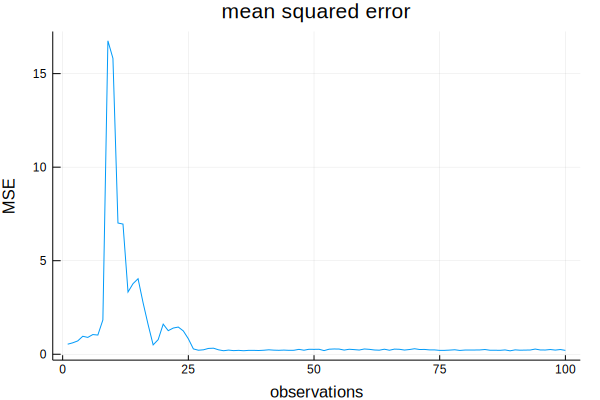

In [31]:
using Plots
plot(MSEs[1:100], title="mean squared error", xlabel="observations", ylabel="MSE", legend=false)

In [34]:
# Plotting predictions
anim = @animate for i in 1:100:length(predictions)
    s = plot();
    ylims!(minimum(actual) - .1, maximum(actual) + .1);
    predicted = predictions[i]
    plot!([actual, predicted], title = "unforeseen data", xlabel="time", ylabel="value", label=["actual", "predicted"])
end
gif(anim, "../gifs/AR-online.gif", fps = 10)

┌ Info: Saved animation to 
│   fn = /Users/albertpod/Documents/Julia/VariationalBayes/gifs/AR-online.gif
└ @ Plots /Users/albertpod/.julia/packages/Plots/gylTh/src/animation.jl:90


Plots.AnimatedGif("/Users/albertpod/Documents/Julia/VariationalBayes/gifs/AR-online.gif")

In [37]:
# Plotting AR coefs
anim = @animate for i in 1:100:length(m_a)
    if !isassigned(m_a, i)
        continue
    end
    s = plot();
    xlims!(coefs[1] - 0.5, coefs[1] + 0.5);
    ylims!(coefs[2] - 0.5, coefs[2] + 0.5);
    plot!([coefs[1]],[coefs[2]], seriestype=:scatter, title = "AR coefs", xlabel="1", ylabel="2")
    plot!([m_a[i][1]],[m_a[i][2]], seriestype=:scatter)
end
gif(anim, "../gifs/AR-coefs.gif", fps = 10)

┌ Info: Saved animation to 
│   fn = /Users/albertpod/Documents/Julia/VariationalBayes/gifs/AR-coefs.gif
└ @ Plots /Users/albertpod/.julia/packages/Plots/gylTh/src/animation.jl:90


Plots.AnimatedGif("/Users/albertpod/Documents/Julia/VariationalBayes/gifs/AR-coefs.gif")

In [38]:
# Plotting noise coefs
anim = @animate for i in 1:100:length(m_a)
    if !isassigned(m_a, i)
        continue
    end
    s = plot();
    xlims!(-.5, .5);
    ylims!(-.5, .5);
    plot!([0.0], [0.0], seriestype=:scatter, title = "noise", xlabel="1")
    plot!([(a_w[i]/b_w[i])^-1], [0.0], seriestype=:scatter)
end
gif(anim, "../gifs/AR-weights.gif", fps = 10)

┌ Info: Saved animation to 
│   fn = /Users/albertpod/Documents/Julia/VariationalBayes/gifs/AR-weights.gif
└ @ Plots /Users/albertpod/.julia/packages/Plots/gylTh/src/animation.jl:90


Plots.AnimatedGif("/Users/albertpod/Documents/Julia/VariationalBayes/gifs/AR-weights.gif")